In [55]:
from utils import *
import shutil
import os
import datetime

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BASE_PATH = "./data"

In [12]:
def load_data(base_path="/data"):
    """ Load the data in PyTorch Tensor.

    :return: (zero_train_matrix, train_data, valid_data, test_data)
         WHERE:
        zero_train_matrix: 2D sparse matrix where missing entries are
        filled with 0.
        train_data: 2D sparse matrix
        valid_data: A dictionary {user_id: list,
        user_id: list, is_correct: list}
        test_data: A dictionary {user_id: list,
        user_id: list, is_correct: list}
    """
    train_matrix = load_train_sparse(base_path).toarray()
    valid_data = load_valid_csv(base_path)
    test_data = load_public_test_csv(base_path)

    # Create copy of train matrix with missing entries set to 0.
    zero_train_matrix = train_matrix.copy()
    zero_train_matrix[np.isnan(train_matrix)] = 0
    
    """
    for j in range(0, zero_train_matrix.shape[1]):
        count = Counter(zero_train_matrix[:,j])
        chance_correct = count[1.0]/(count[0.0]+count[1.0])
        zero_train_matrix[:,j] = np.nan_to_num(zero_train_matrix[:,j], nan=chance_correct)
    """
    
    # Change to Float Tensor for PyTorch.
    zero_train_matrix = torch.FloatTensor(zero_train_matrix)
    train_matrix = torch.FloatTensor(train_matrix)

    return zero_train_matrix, train_matrix, valid_data, test_data


"""Utilities for User Meta Data"""

def to_datetime(string):
    date_list = [int(i) for i in string.split(' ')[0].split('-')]
    date = datetime.datetime(date_list[0],date_list[1],date_list[2])
    return date

def calculate_age(date):
    present=datetime.datetime(2021, 12, 1)
    age = present - date
    age = round(age.days/365)
    return age

def load_user_meta_csv(path):
    if not os.path.exists(path):
            raise Exception("The specified path {} does not exist.".format(path))
    with open(path, "r") as csv_file:
        reader = csv.reader(csv_file)
        # Initialize the data.
        data = {
            "gender": [],
            "user_id": [],
            "premium_pupil": [],
            "age":[]
        }
        for row in reader:
            try:
                data["user_id"].append(int(row[0]))
                data["gender"].append(int(row[1]))
                if row[2]=='':
                    data["age"].append(np.nan)
                else:

                    data["age"].append(calculate_age(to_datetime(row[2])))
                if row[3]=='':
                    data["premium_pupil"].append(np.nan)
                else:
                    data['premium_pupil'].append(int(float(row[3])))
            except ValueError:
                # Pass first row.
                pass
            except IndexError:
                # is_correct might not be available.
                pass
    return data  

def public_load_user_meta_csv(root_dir="/data"):
    """ Load the meta data as a dictionary.

    :param root_dir: str
    :return: A dictionary {user_id: list, question_id: list, is_correct: list}
        WHERE
        user_id: a list of user id.
        question_id: a list of question id.
        is_correct: an empty list.
    """
    path = os.path.join(root_dir, "student_meta.csv")
    return load_user_meta_csv(path)

def meta_to_matrix(path):
    ''' data is dict'''
    
    meta=public_load_user_meta_csv(path)

    mat = np.zeros((len(meta['user_id']), 2,))
    for i in range(len(meta['user_id'])):
        cur_id = meta['user_id'][i]
        age = meta['age'][i]
        premium = meta['premium_pupil'][i]
        gender = meta['gender'][i]
        mat[cur_id][0] = age
        mat[cur_id][1] = premium
        
    # Modify the Matrix
    # Set all NAN to average premium value
    avg_premium = np.nanmean(mat[:,-1])
    mat[:,-1] = np.nan_to_num(mat[:,-1], nan=avg_premium)

    # Set all NAN to average age and normalize between 0-1
    avg_age = np.nanmean(mat[:,-2])
    mat[:,-2] = np.nan_to_num(mat[:,-2], nan=avg_age)
    mat[:,-2] = (mat[:,-2] - np.min(mat[:,-2]))/(np.max(mat[:,-2])-np.min(mat[:,-2]))
    
    return mat 

In [77]:
class AutoEncoder(nn.Module):
    def __init__(self, input, k, output, p):
        """ Initialize a class AutoEncoder.

        :param num_question: int
        :param k: int
        """
        super(AutoEncoder, self).__init__()

        self.g = nn.Linear(input, k)
        self.h = nn.Linear(k, output)
        self.dropout = nn.Dropout(p)

    def get_weight_norm(self):
        """ Return ||W^1||^2 + ||W^2||^2.

        :return: float
        """
        g_w_norm = torch.norm(self.g.weight, 2) ** 2
        h_w_norm = torch.norm(self.h.weight, 2) ** 2
        return g_w_norm + h_w_norm

    def forward(self, inputs):
        """ Return a forward pass given inputs.

        :param inputs: user vector.
        :return: user vector.
        """
        out = torch.sigmoid(self.g(inputs))
        out = self.dropout(out)
        out = torch.sigmoid(self.h(out))
        
        return out


def train(model, lr, lamb, train_data, zero_train_data, valid_data, num_epoch):
    """ Train the neural network, where the objective also includes
    a regularizer.

    :param model: Module
    :param lr: float
    :param lamb: float
    :param train_data: 2D FloatTensor
    :param zero_train_data: 2D FloatTensor
    :param valid_data: Dict
    :param num_epoch: int
    :return: None
    """
    
    # Create checkpoints folder
    if os.path.isdir('./checkpoints'):
        shutil.rmtree('./checkpoints')
    os.mkdir('./checkpoints')
    
    # Tell PyTorch you are training the model.
    model.train()

    # Define optimizers and loss function.
    optimizer = optim.Adam(model.parameters(), lr=lr)
    num_student = train_data.shape[0]

    # For plotting
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    epochs = []
    
    # For early stop
    lowest_valid_loss = float("inf")

    for epoch in range(0, num_epoch):
        train_loss = 0.
        
        for user_id in range(num_student):
            # Forward pass
            input = Variable(zero_train_data[user_id]).unsqueeze(0).to(device)
            output = model(input)

            # Mask the target to only compute the gradient of valid entries.
            target = input.clone()[:, 0:-2].to(device)
            nan_mask = np.isnan(train_data[user_id].unsqueeze(0).numpy())
            target[0][nan_mask] = output[0][nan_mask]
            
            # Loss
            loss = torch.sum((output - target) ** 2.)
            loss_regularized = loss + lamb/2*model.get_weight_norm()
            loss_regularized.backward()
            train_loss += loss.item()
            
            optimizer.step()
            optimizer.zero_grad()
        
        # Normalized training and validation losses for plotting
        train_loss /= torch.sum(torch.isnan(train_matrix) == False)    
        valid_loss, valid_acc, _ = evaluate(model, zero_train_data, valid_data)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        epochs.append(epoch)
        
        # Save best model
        if valid_loss < lowest_valid_loss:
            lowest_valid_loss = valid_loss
            torch.save(model.state_dict(), f'./checkpoints/epoch_{epoch}.pt')
            
        print("Epoch: {} \tTrain Loss: {:.6f} \tValid Loss: {:.6f} \tValid Acc: {}".format(epoch, train_loss, valid_loss, valid_acc))
    
    # Plot training curves
    plt.figure(1)
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, valid_losses, label="Valid")
    plt.legend()
    plt.title("Train/Validation Loss Curve")
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.show()

    
def evaluate(model, train_data, valid_data, threshold=0.5):
    # Tell PyTorch you are evaluating the model.
    model.eval()
    
    predictions = []
    correct = 0
    total = 0
    loss = 0

    for i, u in enumerate(valid_data["user_id"]):
        inputs = Variable(train_data[u]).unsqueeze(0).to(device)
        output = model(inputs)
        
        # Prediction
        pred = output[0][valid_data["question_id"][i]].item() >= threshold
        predictions.append(pred)
        
        # Accuracy
        if pred == valid_data["is_correct"][i]:
            correct += 1
        total += 1
        
        # Loss
        loss += ((pred - valid_data["is_correct"][i]) ** 2.)
              
    acc = correct / float(total)
    avg_loss = loss/len(valid_data["user_id"])
    
    return avg_loss, acc, predictions

Epoch: 0 	Train Loss: 0.266017 	Valid Loss: 0.476432 	Valid Acc: 0.5235675980807225
Epoch: 1 	Train Loss: 0.247376 	Valid Loss: 0.443974 	Valid Acc: 0.5560259666948913
Epoch: 2 	Train Loss: 0.241347 	Valid Loss: 0.422100 	Valid Acc: 0.5779000846740051
Epoch: 3 	Train Loss: 0.234421 	Valid Loss: 0.402625 	Valid Acc: 0.5973751058425063
Epoch: 4 	Train Loss: 0.227577 	Valid Loss: 0.393452 	Valid Acc: 0.6065481230595541
Epoch: 5 	Train Loss: 0.222139 	Valid Loss: 0.383291 	Valid Acc: 0.6167090036692069
Epoch: 6 	Train Loss: 0.218390 	Valid Loss: 0.379763 	Valid Acc: 0.6202370872142252
Epoch: 7 	Train Loss: 0.215854 	Valid Loss: 0.378775 	Valid Acc: 0.6212249506068304
Epoch: 8 	Train Loss: 0.214005 	Valid Loss: 0.377646 	Valid Acc: 0.6223539373412362
Epoch: 9 	Train Loss: 0.212504 	Valid Loss: 0.372848 	Valid Acc: 0.6271521309624611
Epoch: 10 	Train Loss: 0.211174 	Valid Loss: 0.371719 	Valid Acc: 0.628281117696867
Epoch: 11 	Train Loss: 0.209928 	Valid Loss: 0.371719 	Valid Acc: 0.62828111

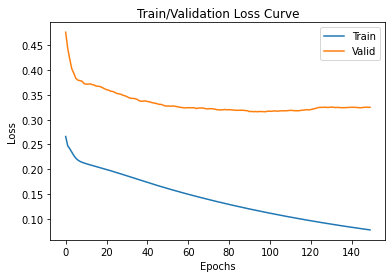

In [121]:
zero_train_matrix, train_matrix, valid_data, test_data = load_data(BASE_PATH)

meta_train_matrix = meta_to_matrix(BASE_PATH)
# meta_train_matrix[np.isnan(meta_train_matrix)] = 0
meta_train_matrix = torch.FloatTensor(meta_train_matrix)
augmented_train_matrix = torch.hstack((zero_train_matrix, meta_train_matrix))


# Set model hyperparameters.
k = 50
lr = 0.0001
num_epoch = 150
lamb = 0.0001
dropout = 0.8

model = AutoEncoder(train_matrix.shape[1]+2, k, train_matrix.shape[1], dropout)
model.to(device)

train(model, lr, lamb, train_matrix, augmented_train_matrix, valid_data, num_epoch)

In [124]:
# Evaluate
_, test_acc, predictions = evaluate(model, augmented_train_matrix, test_data)
print(test_acc)

0.6836014676827548


In [123]:
# Load model
model = AutoEncoder(train_matrix.shape[1]+2 , k, train_matrix.shape[1], dropout)
model.load_state_dict(torch.load('./checkpoints/epoch_94.pt'))
model.eval()
model.to(device)

AutoEncoder(
  (g): Linear(in_features=1776, out_features=50, bias=True)
  (h): Linear(in_features=50, out_features=1774, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)

Sensitivity= 0.6191570881226054
Specificity= 0.7211796246648794


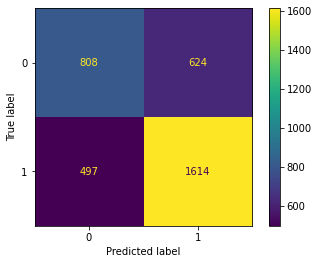

In [125]:
# Confusion Matrix
cm = confusion_matrix(test_data["is_correct"], predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

sensitivity = cm[0, 0]/(cm[0, 0] + cm[1, 0])
specificity = cm[1, 1]/(cm[1, 1] + cm[0, 1])

print("Sensitivity=", sensitivity)
print("Specificity=", specificity)